# Recommendations with IBM

In this notebook, I will be putting your recommendation skills to use on real data from the IBM Watson Studio platform. 

By following the table of contents, you will build out a number of different methods for making recommendations that can be used for different situations. 


## Table of Contents

I. [Exploratory Data Analysis](#Exploratory-Data-Analysis)<br>
II. [Rank Based Recommendations](#Rank)<br>
III. [User-User Based Collaborative Filtering](#User-User)<br>
IV. [Content Based Recommendations (EXTRA - NOT REQUIRED)](#Content-Recs)<br>
V. [Matrix Factorization](#Matrix-Fact)<br>
VI. [Extras & Concluding](#conclusions)

In [379]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import project_tests as t


from nltk.tokenize import word_tokenize
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk import WordNetLemmatizer
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from nltk.corpus import stopwords
import time
import re

nltk.download('wordnet')
nltk.download('stopwords')


%matplotlib inline

df = pd.read_csv('data/user-item-interactions.csv')
df_content = pd.read_csv('data/articles_community.csv')
del df['Unnamed: 0']
del df_content['Unnamed: 0']

# Show df to get an idea of the data
print(df.shape, df.isnull().sum())
df.head()

(45993, 3) article_id     0
title          0
email         17
dtype: int64


,article_id,title,email
0,1430.0,"using pixiedust for fast, flexible, and easier data analysis and experimentation",ef5f11f77ba020cd36e1105a00ab868bbdbf7fe7
1,1314.0,healthcare python streaming application demo,083cbdfa93c8444beaa4c5f5e0f5f9198e4f9e0b
2,1429.0,use deep learning for image classification,b96a4f2e92d8572034b1e9b28f9ac673765cd074
3,1338.0,ml optimization using cognitive assistant,06485706b34a5c9bf2a0ecdac41daf7e7654ceb7
4,1276.0,deploy your python model as a restful api,f01220c46fc92c6e6b161b1849de11faacd7ccb2


In [2]:
# Show df_content to get an idea of the data
print(df_content.shape, df.isnull().sum().sum())
df_content.head()

(1056, 5) 17


,doc_body,doc_description,doc_full_name,doc_status,article_id
0,Skip navigation Sign in SearchLoading...\r\n\r...,Detect bad readings in real time using Python ...,Detect Malfunctioning IoT Sensors with Streami...,Live,0
1,No Free Hunch Navigation * kaggle.com\r\n\r\n ...,"See the forest, see the trees. Here lies the c...",Communicating data science: A guide to present...,Live,1
2,☰ * Login\r\n * Sign Up\r\n\r\n * Learning Pat...,Here’s this week’s news in Data Science and Bi...,"This Week in Data Science (April 18, 2017)",Live,2
3,"DATALAYER: HIGH THROUGHPUT, LOW LATENCY AT SCA...",Learn how distributed DBs solve the problem of...,DataLayer Conference: Boost the performance of...,Live,3
4,Skip navigation Sign in SearchLoading...\r\n\r...,This video demonstrates the power of IBM DataS...,Analyze NY Restaurant data using Spark in DSX,Live,4


### <a class="anchor" id="Exploratory-Data-Analysis">Part I : Exploratory Data Analysis</a>

Use the dictionary and cells below to provide some insight into the descriptive statistics of the data.

`1.` What is the distribution of how many articles a user interacts with in the dataset?  Provide a visual and descriptive statistics to assist with giving a look at the number of times each user interacts with an article.  

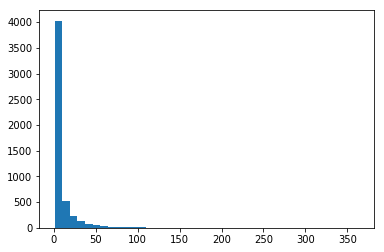

In [3]:
plt.hist(df.email.value_counts(), bins=40);

In [4]:
df.email.value_counts().describe()

count    5148.000000
mean        8.930847
std        16.802267
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       364.000000
Name: email, dtype: float64

In [5]:
# Fill in the median and maximum number of user_article interactios below

median_val = 3  # 50% of individuals interact with ____ number of articles or fewer.
max_views_by_user = 364  # The maximum number of user-article interactions by any 1 user is ______.

`2.` Explore and remove duplicate articles from the **df_content** dataframe.  

In [6]:
# Find and explore duplicate articles
df_content.article_id.duplicated().sum()

5

In [7]:
# Remove any rows that have the same article_id - only keep the first
df_content = df_content.drop_duplicates(subset="article_id")

assert df_content.article_id.duplicated().sum() == 0
df_content.shape

(1051, 5)

`3.` Use the cells below to find:

**a.** The number of unique articles that have an interaction with a user.  
**b.** The number of unique articles in the dataset (whether they have any interactions or not).<br>
**c.** The number of unique users in the dataset. (excluding null values)<br> 
**d.** The number of user-article interactions in the dataset.

In [8]:
unique_articles = df.article_id.nunique() # The number of unique articles that have at least one interaction
total_articles = df_content.article_id.nunique() # The number of unique articles on the IBM platform
unique_users = df.email.nunique() # The number of unique users
user_article_interactions = df.shape[0]# The number of user-article interactions

unique_articles, total_articles, unique_users, user_article_interactions

(714, 1051, 5148, 45993)

`4.` Use the cells below to find the most viewed **article_id**, as well as how often it was viewed.  After talking to the company leaders, the `email_mapper` function was deemed a reasonable way to map users to ids.  There were a small number of null values, and it was find using other information that all of these null values likely belonged to a single user.

In [468]:
## No need to change the code here - this will be helpful for later parts of the notebook
# Run this cell to map the user email to a user_id column and remove the email column

def email_mapper():
    coded_dict = dict()
    cter = 1
    email_encoded = []
    
    for val in df['email']:
        if val not in coded_dict:
            coded_dict[val] = cter
            cter+=1
        
        email_encoded.append(coded_dict[val])
    return email_encoded

email_encoded = email_mapper()
del df['email']
df['user_id'] = email_encoded

# show header
print(df.shape, df.isnull().sum().sum())
df.head()

(45993, 3) 0


,article_id,title,user_id
0,1430.0,"using pixiedust for fast, flexible, and easier data analysis and experimentation",1
1,1314.0,healthcare python streaming application demo,2
2,1429.0,use deep learning for image classification,3
3,1338.0,ml optimization using cognitive assistant,4
4,1276.0,deploy your python model as a restful api,5


In [10]:
df.article_id.value_counts().iloc[:5]

1429.0    937
1330.0    927
1431.0    671
1427.0    643
1364.0    627
Name: article_id, dtype: int64

In [11]:
most_viewed_article_id = "1429.0" # The most viewed article in the dataset as a string with one value following the decimal 
max_views = 937# The most viewed article in the dataset was viewed how many times?

most_viewed_article_id, max_views

('1429.0', 937)

In [12]:
## If you stored all your results in the variable names above, 
## you shouldn't need to change anything in this cell

sol_1_dict = {
    '`50% of individuals have _____ or fewer interactions.`': median_val,
    '`The total number of user-article interactions in the dataset is ______.`': user_article_interactions,
    '`The maximum number of user-article interactions by any 1 user is ______.`': max_views_by_user,
    '`The most viewed article in the dataset was viewed _____ times.`': max_views,
    '`The article_id of the most viewed article is ______.`': most_viewed_article_id,
    '`The number of unique articles that have at least 1 rating ______.`': unique_articles,
    '`The number of unique users in the dataset is ______`': unique_users,
    '`The number of unique articles on the IBM platform`': total_articles
}

# Test your dictionary against the solution
t.sol_1_test(sol_1_dict)

It looks like you have everything right here! Nice job!


In [13]:
# Before move on, I have to convert the type of "user_id" in "df" into int
df.info(), df_content.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45993 entries, 0 to 45992
Data columns (total 3 columns):
article_id    45993 non-null float64
title         45993 non-null object
user_id       45993 non-null int64
dtypes: float64(1), int64(1), object(1)
memory usage: 1.1+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 1051 entries, 0 to 1055
Data columns (total 5 columns):
doc_body           1037 non-null object
doc_description    1048 non-null object
doc_full_name      1051 non-null object
doc_status         1051 non-null object
article_id         1051 non-null int64
dtypes: int64(1), object(4)
memory usage: 49.3+ KB


(None, None)

In [14]:
# assert all article_id can be converted to int
assert (df.article_id != df.article_id.astype(int)).sum() == 0

# convert
df.article_id = df.article_id.astype(int)

### <a class="anchor" id="Rank">Part II: Rank-Based Recommendations</a>

Unlike in the earlier lessons, we don't actually have ratings for whether a user liked an article or not.  We only know that a user has interacted with an article.  In these cases, the popularity of an article can really only be based on how often an article was interacted with.

`1.` Fill in the function below to return the **n** top articles ordered with most interactions as the top. Test your function using the tests below.

In [15]:
df.shape[0], df[["title", "article_id"]].duplicated().sum()

(45993, 45279)

In [16]:
def get_top_articles(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles = df.title.value_counts().index.tolist()[:n]
    
    return top_articles # Return the top article titles from df (not df_content)

def get_top_article_ids(n, df=df):
    '''
    INPUT:
    n - (int) the number of top articles to return
    df - (pandas dataframe) df as defined at the top of the notebook 
    
    OUTPUT:
    top_articles - (list) A list of the top 'n' article titles 
    
    '''
    # Your code here
    top_articles = df.article_id.value_counts().index.tolist()[:n]
 
    return top_articles # Return the top article ids

In [17]:
print(get_top_articles(10))
print(get_top_article_ids(10))

['use deep learning for image classification', 'insights from new york car accident reports', 'visualize car data with brunel', 'use xgboost, scikit-learn & ibm watson machine learning apis', 'predicting churn with the spss random tree algorithm', 'healthcare python streaming application demo', 'finding optimal locations of new store using decision optimization', 'apache spark lab, part 1: basic concepts', 'analyze energy consumption in buildings', 'gosales transactions for logistic regression model']
[1429, 1330, 1431, 1427, 1364, 1314, 1293, 1170, 1162, 1304]


In [18]:
# Test your function by returning the top 5, 10, and 20 articles
top_5 = get_top_articles(5)
top_10 = get_top_articles(10)
top_20 = get_top_articles(20)

# Test each of your three lists from above
t.sol_2_test(get_top_articles)

Your top_5 looks like the solution list! Nice job.
Your top_10 looks like the solution list! Nice job.
Your top_20 looks like the solution list! Nice job.


### <a class="anchor" id="User-User">Part III: User-User Based Collaborative Filtering</a>


`1.` Use the function below to reformat the **df** dataframe to be shaped with users as the rows and articles as the columns.  

* Each **user** should only appear in each **row** once.


* Each **article** should only show up in one **column**.  


* **If a user has interacted with an article, then place a 1 where the user-row meets for that article-column**.  It does not matter how many times a user has interacted with the article, all entries where a user has interacted with an article should be a 1.  


* **If a user has not interacted with an item, then place a zero where the user-row meets for that article-column**. 

Use the tests to make sure the basic structure of your matrix matches what is expected by the solution.

In [19]:
df.head()

,article_id,title,user_id
0,1430,"using pixiedust for fast, flexible, and easier...",1
1,1314,healthcare python streaming application demo,2
2,1429,use deep learning for image classification,3
3,1338,ml optimization using cognitive assistant,4
4,1276,deploy your python model as a restful api,5


In [20]:
# create the user-article matrix with 1's and 0's

def create_user_item_matrix(df):
    '''
    INPUT:
    df - pandas dataframe with article_id, title, user_id columns
    
    OUTPUT:
    user_item - user item matrix 
    
    Description:
    Return a matrix with user ids as rows and article ids on the columns with 1 values where a user interacted with 
    an article and a 0 otherwise
    '''
    # Fill in the function here
    user_item = df.groupby(['user_id', 'article_id'])['title'].count().unstack()
    user_item = (~user_item.isnull()).replace({True:1,False:0})
    
    return user_item # return the user_item matrix 

user_item = create_user_item_matrix(df)

In [21]:
## Tests: You should just need to run this cell.  Don't change the code.
assert user_item.shape[0] == 5149, "Oops!  The number of users in the user-article matrix doesn't look right."
assert user_item.shape[1] == 714, "Oops!  The number of articles in the user-article matrix doesn't look right."
assert user_item.sum(axis=1)[1] == 36, "Oops!  The number of articles seen by user 1 doesn't look right."
print("You have passed our quick tests!  Please proceed!")

You have passed our quick tests!  Please proceed!


In [22]:
user_item.iloc[:10,:10]

article_id,0,2,4,8,9,12,14,15,16,18
user_id,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,1,0,0,0
9,0,0,0,0,0,0,1,0,1,0


`2.` Complete the function below which should take a user_id and provide an ordered list of the most similar users to that user (from most similar to least similar).  The returned result should not contain the provided user_id, as we know that each user is similar to him/herself. Because the results for each user here are binary, it (perhaps) makes sense to compute similarity as the dot product of two users. 

Use the tests to test your function.

In [23]:
def find_similar_users(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user_id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    similar_users - (list) an ordered list where the closest users (largest dot product users)
                    are listed first. This list doesn't include the given user 
    
    Description:
    Computes the similarity of every pair of users based on the dot product
    Returns an ordered
    
    '''
    # compute similarity of each user to the provided user
    similarirty_matrix = user_item.dot(np.transpose(user_item))

    # user_id and row=column index in the similarity matrix
    user_id_idx = pd.Series(user_item.index)
    
    # find row index corresponding to privided user_id
    user_idx = user_id_idx.index[user_id_idx == user_id][0]
    
    # extract a row of provided user_id from user_item matrix
    user_row = pd.Series(similarirty_matrix.iloc[user_idx], index=user_item.index)

    # remove the provided user oneself
    most_similar_users = user_row[user_row.index != user_id]
    
    # sort and convert to list
    most_similar_users = most_similar_users.sort_values(ascending=False).index.tolist()
    
    return most_similar_users # return a list of the users in order from most to least similar
        

In [24]:
# Do a spot check of your function
print("The 10 most similar users to user 1 are: {}".format(find_similar_users(1)[:10]))
print("The 5 most similar users to user 3933 are: {}".format(find_similar_users(3933)[:5]))
print("The 3 most similar users to user 46 are: {}".format(find_similar_users(46)[:3]))

The 10 most similar users to user 1 are: [3933, 23, 3782, 203, 4459, 3870, 131, 4201, 46, 3697]
The 5 most similar users to user 3933 are: [1, 3782, 23, 203, 4459]
The 3 most similar users to user 46 are: [4201, 3782, 23]


`3.` Now that you have a function that provides the most similar users to each user, you will want to use these users to find articles you can recommend.  Complete the functions below to return the articles you would recommend to each user. 

In [125]:
def get_article_names(article_ids, df=df):
    '''
    INPUT:
    article_ids - (list) a list of article ids
    df - (pandas dataframe) df as defined at the top of the notebook
    
    OUTPUT:
    article_names - (list) a list of article names associated with the list of article ids 
                    (this is identified by the title column)
    '''
    article_names = []
    
    # Your code here
    for each_article_id in article_ids:
        #print(df.article_id,each_article_id)
        article_names.append(df.title[df.article_id == each_article_id].iloc[0])
    
    return article_names # Return the article names associated with list of article ids

In [126]:
def get_user_articles(user_id, user_item=user_item):
    '''
    INPUT:
    user_id - (int) a user id
    user_item - (pandas dataframe) matrix of users by articles: 
                1's when a user has interacted with an article, 0 otherwise
    
    OUTPUT:
    article_ids - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user
    '''
    # extract a given user's row from user_id
    user_row = user_item.loc[user_id]
    
    # extract article_ids which the given user has read
    article_ids = user_row.index[user_row == 1].tolist()
    
    # get a list of article_names from the list of movie_ids
    article_names = get_article_names(article_ids)
    
    return article_ids, article_names # return the ids and names

In [127]:
def user_user_recs(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    Users who are the same closeness are chosen arbitrarily as the 'next' user
    
    For the user where the number of recommended articles starts below m 
    and ends exceeding m, the last items are chosen arbitrarily
    
    '''
    # Your code here
    recs = []
    
    # get a list of article names which privided user has already read
    read_names = get_user_articles(user_id)[1]
    
    # get a list of ids of neighbors 
    neighbors = find_similar_users(user_id)
    
    # for each of neighbors...
    for each_neighbor in neighbors:
        # get the list of article names the neighbow has read
        neighbor_article_names = get_user_articles(each_neighbor)[1]
        # remove article names which the given user has already read
        articles_to_be_added = [a for a in neighbor_article_names if a not in read_names]
        # add the list to recommendation list for the given user
        recs.append(a)

    return recs[:m] # return your recommendations for this user_id    

In [128]:
# Check Results
get_article_names(user_user_recs(1, 10)) # Return 10 recommendations for user 1

KeyboardInterrupt: 

In [129]:
# Test your functions here - No need to change this code - just run this cell
assert set(get_article_names([1024, 1176, 1305, 1314, 1422, 1427])) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_article_names([1320, 232, 844])) == set(['housing (2015): united states demographic measures','self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook']), "Oops! Your the get_article_names function doesn't work quite how we expect."
assert set(get_user_articles(20)[0]) == set([1320, 232, 844])
assert set(get_user_articles(20)[1]) == set(['housing (2015): united states demographic measures', 'self-service data preparation with ibm data refinery','use the cloudant-spark connector in python notebook'])
assert set(get_user_articles(2)[0]) == set([1024, 1176, 1305, 1314, 1422, 1427])
assert set(get_user_articles(2)[1]) == set(['using deep learning to reconstruct high-resolution audio', 'build a python app on the streaming analytics service', 'gosales transactions for naive bayes model', 'healthcare python streaming application demo', 'use r dataframes & ibm watson natural language understanding', 'use xgboost, scikit-learn & ibm watson machine learning apis'])
print("If this is all you see, you passed all of our tests!  Nice job!")

If this is all you see, you passed all of our tests!  Nice job!


`4.` Now we are going to improve the consistency of the **user_user_recs** function from above.  

* Instead of arbitrarily choosing when we obtain users who are all the same closeness to a given user - choose the users that have the most total article interactions before choosing those with fewer article interactions.


* Instead of arbitrarily choosing articles from the user where the number of recommended articles starts below m and ends exceeding m, choose articles with the articles with the most total interactions before choosing those with fewer total interactions. This ranking should be  what would be obtained from the **top_articles** function you wrote earlier.

In [130]:
# Before move on, I will add a new column to "df"
# I will add a column which signifies how many times each of articles were read by users

df_with_count = df.groupby("article_id").title.count().reset_index()
df_with_count = df_with_count.rename(columns={"title":"num_read"})

df2 = df.copy().merge(df_with_count, on="article_id")

# I sort this dataframe by this new column "num_read"
df2 = df2.sort_values(by="num_read", ascending=False)
df2.head()

,article_id,title,user_id,num_read
1770,1429,use deep learning for image classification,4323,937
1089,1429,use deep learning for image classification,82,937
1099,1429,use deep learning for image classification,1041,937
1098,1429,use deep learning for image classification,860,937
1097,1429,use deep learning for image classification,72,937


In [131]:
def get_top_sorted_users(user_id, df=df, user_item=user_item):
    '''
    INPUT:
    user_id - (int)
    df - (pandas dataframe) df as defined at the top of the notebook 
    user_item - (pandas dataframe) matrix of users by articles: 
            1's when a user has interacted with an article, 0 otherwise
    
            
    OUTPUT:
    neighbors_df - (pandas dataframe) a dataframe with:
                    neighbor_id - is a neighbor user_id
                    similarity - measure of the similarity of each user to the provided user_id
                    num_interactions - the number of articles viewed by all user
                    
    Other Details - sort the neighbors_df by the similarity and then by number of interactions where 
                    highest of each is higher in the dataframe
                    The given user oneself is not included.
    '''
    
    # Your code here
    # create similarity matrix between users
    similarity_matrix = user_item.dot(user_item.transpose())
    
    # exract a row of the given user
    user_row = similarity_matrix[similarity_matrix.index == user_id].iloc[0]
    users_interaction = df.groupby("user_id").count()["title"]
    
    # make a dataframe with 2 columns "user_id" and "similarity"
    sim_df = pd.DataFrame({"similarity":user_row}).reset_index()
    
    # make a dataframe with 2 columns "user_id" and "num_interactions"
    inter_df = pd.DataFrame({"num_interactions":users_interaction}).reset_index()
    
    # merge 2 dataframes
    neighbors_df = sim_df.merge(inter_df, on="user_id")
    
    # change the column name from "user_id" to "neighbor_id"
    neighbors_df.rename(columns = {"user_id" : "neihbor_id"})
    
    # remove the given user oneself
    neighbors_df = neighbors_df[neighbors_df.user_id != user_id]
    
    # sort users by "similarity" and then "num_interactions"
    neighbors_df = neighbors_df.sort_values(by=["similarity", "num_interactions"], ascending=False)
        
    return neighbors_df.user_id.tolist() # Return the dataframe specified in the doc_string

In [132]:
df2.sort_values("num_read", ascending=False).head()

,article_id,title,user_id,num_read
1770,1429,use deep learning for image classification,4323,937
1307,1429,use deep learning for image classification,665,937
1295,1429,use deep learning for image classification,23,937
1305,1429,use deep learning for image classification,305,937
1304,1429,use deep learning for image classification,21,937


In [139]:
def get_user_articles_sorted(user_id, df2=df2):
    '''
    INPUT:
    user_id - (int) a user id
    df2 - (pandas dataframe) dataframe whose each row means each interaction with a user and an article.
                                Column "num_read" as well as "article_id", "title", "user_id" is needed.
    OUTPUT:
    article_ids_uniq - (list) a list of the article ids seen by the user
    article_names - (list) a list of article names associated with the list of article ids 
    
    Description:
    Provides a list of the article_ids and article titles that have been seen by a user.
    These articles are sorted in the descending order on how mamy times articles are read by users.
    '''
    # extract a given user's row from user_id
    user_row = user_item.loc[user_id]
    
    # make a sorted and grouped dataframe from "df" like above.
    # This helps to get the sorted movies list
    df_sorted = df2.sort_values("num_read", ascending=False)
    
    # extract article_ids which the given user has read
    article_ids = list((df_sorted[df_sorted["user_id"] == user_id]["article_id"]))
    
    # remove duplicated elements
    article_ids_uniq = []
    
    for x in article_ids:
        if x not in article_ids_uniq:
            article_ids_uniq.append(x)

    # get list of article_names from the list of movie_ids
    article_names = get_article_names(article_ids_uniq)

    return article_ids_uniq, article_names # return the ids and names

In [142]:
# Just check how this works
get_user_articles_sorted(115, df2=df2)

([1293, 1393, 1336, 1343, 1395, 1428, 1317, 131, 1350, 632],
 ['finding optimal locations of new store using decision optimization',
  'the nurse assignment problem',
  'learn basics about notebooks and apache spark',
  'maximize oil company profits',
  'the unit commitment problem',
  'use decision optimization to schedule league games',
  'house building with worker skills',
  'simple graphing with ipython and\xa0pandas',
  'model a golomb ruler',
  'hyperparameter optimization: sven hafeneger'])

In [140]:
def user_user_recs_part2(user_id, m=10):
    '''
    INPUT:
    user_id - (int) a user id
    m - (int) the number of recommendations you want for the user
    
    OUTPUT:
    recs - (list) a list of recommendations for the user by article id
    rec_names - (list) a list of recommendations for the user by article title
    
    Description:
    Loops through the users based on closeness to the input user_id
    For each user - finds articles the user hasn't seen before and provides them as recs
    Does this until m recommendations are found
    
    Notes:
    * Choose the users that have the most total article interactions 
    before choosing those with fewer article interactions.

    * Choose articles with the articles with the most total interactions 
    before choosing those with fewer total interactions. 
   
    '''
    # Your code here
    
    recs = []

    # get dataframe of neighbors sorted by similarity and then num_interactions to articles
    neighbor_ids_sorted = get_top_sorted_users(user_id, df=df, user_item=user_item).user_id
    
    # loop through each of neighbors
    for each_neighbor_id in neighbors_df.user_id:

        recs.extend(get_user_articles_sorted(each_neighbor_id))
        
        if len(recs) >= m:
            break
            
    recs = recs[:m]
    rec_names = get_article_names(recs, df=df)
    
    return recs, rec_names

In [66]:
# Just check this works
user_user_recs_part2(1, m=1), user_user_recs_part2(131, m=10)

KeyboardInterrupt: 

`5.` Use your functions from above to correctly fill in the solutions to the dictionary below.  Then test your dictionary against the solution.  Provide the code you need to answer each following the comments below.

In [146]:
### Tests with a dictionary of results
# Find the user that is most similar to user 1 
user1_most_sim = get_top_sorted_users(1, df=df, user_item=user_item)[0]
user1_most_sim

3933

In [150]:
# Find the 10th most similar user to user 131
user131_10th_sim = get_top_sorted_users(131, df=df, user_item=user_item)[9]
user131_10th_sim

242

In [151]:
## Dictionary Test Here
sol_5_dict = {
    'The user that is most similar to user 1.': user1_most_sim, 
    'The user that is the 10th most similar to user 131': user131_10th_sim
}

t.sol_5_test(sol_5_dict)

This all looks good!  Nice job!


`7.` Using your existing functions, provide the top 10 recommended articles you would provide for the a new user below.  You can test your function against our thoughts to make sure we are all on the same page with how we might make a recommendation.

In [389]:
new_user = 0

# What would your recommendations be for this new user '0.0'?  As a new user, they have no observed articles.
# Provide a list of the top 10 article ids you would give to 
new_user_recs = get_top_article_ids(10)# Your recommendations here

new_user_recs

[1429, 1330, 1431, 1427, 1364, 1314, 1293, 1170, 1162, 1304]

In [390]:
assert set(new_user_recs) == set([1429, 1330, 1431, 1427, 1364, 1314, 1293, 1170, 1162, 1304]), "Oops!  It makes sense that in this case we would want to recommend the most popular articles, because we don't know anything about these users."

print("That's right!  Nice job!")

That's right!  Nice job!


### <a class="anchor" id="Content-Recs">Part IV: Content Based Recommendations (EXTRA - NOT REQUIRED)</a>

Another method we might use to make recommendations is to perform a ranking of the highest ranked articles associated with some term.  You might consider content to be the **doc_body**, **doc_description**, or **doc_full_name**.  There isn't one way to create a content based recommendation, especially considering that each of these columns hold content related information.  

`1.` Use the function body below to create a content based recommender.  

### This part is NOT REQUIRED to pass this project.  However, you may choose to take this on as an extra way to show off your skills.

> I implement contene-based recommendation using the "doc_full_name" and "doc_description" of articles. First I made a CountVectorizer matrix from "df_content" and get the similar matrix by the dot product to find similat articles from a given article ids. 

In [214]:
def tokenize(text):
    
    text = re.sub(r"[^a-zA-Z0-9]", " ", text)
    tokens = word_tokenize(text)
    
    lemmatizer = WordNetLemmatizer()
    clean_tokens = []
    
    for token in tokens:
        clean_tok = lemmatizer.lemmatize(token).lower().strip()
        
        # remove stop words 
        if clean_tok not in set(stopwords.words("english")):
            clean_tokens.append(clean_tok)
        
    return clean_tokens

In [285]:
 def get_sim_matrix(df_content):
    '''
    Input:
        df_content: (pandas DataFrame) datafrmae whose each row represents each article
    
    Output:
        similar_df: (pandas SparseDataFrame) dataframe of simmilarity martix between articles
    '''
    
    df_content2 = df_content.copy()
    df_content2["doc_for_count"]= (df_content.doc_description + " " + df_content.doc_full_name)

    # get countvectorizer of doc data
    cv = CountVectorizer(tokenizer=tokenize)
    cv_matrix = cv.fit_transform(df_content2.doc_for_count.astype(str).values)

    # get similarity matrix 
    similar_matrix = cv_matrix.dot(cv_matrix.transpose())
    similar_matrix.shape

    # use this to convert similarity matrix into in pandas dataframe
    similar_df = pd.SparseDataFrame(similar_matrix, index=list(df_content2.article_id), columns=list(df_content2.article_id))
    
    return similar_df

In [354]:
def make_content_recs_from_article(article_id, n=5, df_content=df_content):
    '''
    INPUT:
        article_id: (int) article id whose similar articles would be searched.
        n: (int) number of article ids to be returned. 
            If enough articles to be recommended were not found, this function returns as many ids as possible.
    OUTPUT:
        sim_article_ids: (list) list of similar article ids
    
    NOTES:
        This function returns n article ids which are similar to the article.
        They are ordered from the most similar one to the least.
    '''
    
    # get similarity matrix dataframe between articles
    sim_matrix = get_sim_matrix(df_content)
    
    # get sorted articles series which are in ascending order
    sorted_similar_ids = pd.Series(sim_matrix.loc[article_id].sort_values(ascending=False))
    
    # remove NaNs (which means 0, no related at all)
    sorted_similar_ids = sorted_similar_ids.index[~np.isnan(sorted_similar_ids)]

    # remove the given article id itself.
    sim_article_ids = sorted_similar_ids[sorted_similar_ids != article_id].tolist()

    return sim_article_ids[:n]

In [355]:
# Just a little check
make_content_recs_from_article(1)

[720, 764, 986, 363, 349]

In [359]:
# Just a little check
pd.options.display.max_colwidth = 100
df_content[df_content.article_id.isin([1,720,986])]

,doc_body,doc_description,doc_full_name,doc_status,article_id
1,No Free Hunch Navigation * kaggle.com\r\n\r\n * kaggle.com\r\n\r\nCommunicating data science: A ...,"See the forest, see the trees. Here lies the challenge in both performing and presenting an anal...",Communicating data science: A guide to presenting your work,Live,1
722,Jump to navigation\r\n\r\n * Twitter\r\n * LinkedIn\r\n * Facebook\r\n\r\n * About\r\n * Contact...,This data visualization playbook series can help data scientists and data analyst professionals ...,Data Visualization Playbook: Telling the Data Story,Live,720
991,* R for Data Science\r\n * \r\n * Welcome\r\n * 1 Introduction * 1.1 What you will learn\r\n ...,This book will teach you how to do data science with R: You’ll learn how to get your data into R...,R for Data Science,Live,986


In [374]:
df_content[df_content.article_id == 901]
df_content.article_id.duplicated().sum()

0

`2.` Now that you have put together your content-based recommendation system, use the cell below to write a summary explaining how your content based recommender works.  Do you see any possible improvements that could be made to your function?  Is there anything novel about your content based recommender?

> The content-based recommendation system which is implemented by function "make_content_recs_from_article()" takes 3 steps below.
>
>1. Create a similarity matrix between articles by using function "get_sim_matrix()". In this function, the movies' doc_description and doc_full_name are used to get countvectorizer matrix representing the frequency of each words. Following this, calculate the dot product of this and its transpose matrix and get similarity matrix.
>
>2. Focus on the corresponding row of the given movie in the similarity matrix and then get how similar other articles are to the given article. Movie ids are then ordered by "similarity" to the given article. In this process, articles which has 0 "similarity" (i.e. element is 0) and the id of the given article itself are removed.
>
>3. Return ids of similar movies. If there are not enough movies which are similar to the given movie, function "make_content_recs_from_articles()" returns as many ids as possible.


`3.` Use your content-recommendation system to make recommendations for the below scenarios based on the comments.  Again no tests are provided here, because there isn't one right answer that could be used to find these content based recommendations.


**make recommendations for a brand new user**
> There is no way to recommend articles for new users by collaborating filtering recommendation,
> so I have to rely on  knowledge based reomcommendation in this case. 

In [420]:
# make recommendations for a brand new user
rec_for_new_user = get_top_article_ids(5)

**make a recommendations for a user who only has interacted with article id '1427.0'**

> There is no content info about article 1427 in "df_column". However from "df", I can find other 643 users' interaction with this article. These 643 users can be considered to be "neighbors" of this new user. 
>
> I will focus on article ids these users read aside from 1427. It should make sense that more an article is read by more neighbors, the better the article should be recommended.

In [469]:
# make a recommendations for a user who only has interacted with article id '1427.0'

# neighbor ids (users who read article 634)
neighbors = df[df.article_id == 1427].user_id.tolist()

from collections import defaultdict

# dictionary to count how many times each article 
articles_count = defaultdict(int)


# for each of neighbor,,,
for neighbor_id in neighbors:

    # for each article which that neighboer neighbor has read 
    for article_id in get_user_articles(neighbor_id)[0]:

        # count that article 
        articles_count[article_id] += 1

# convert dict to list and sort them in descending order
rec_ids = pd.Series(articles_count).sort_values(ascending=False)
rec_ids[:10]

1427    643
1364    258
1276    257
1314    257
1429    246
1338    242
1185    232
1436    218
1354    217
1330    206
dtype: int64

In [470]:
# 5 top articles to be recommended
rec_ids.index.tolist()[:5]

[1427, 1364, 1276, 1314, 1429]

### <a class="anchor" id="Matrix-Fact">Part V: Matrix Factorization</aIn this part of the notebook, you will build use matrix factorization to make article recommendations to the users on the IBM Watson Studio platform.

`1.` You should have already created a **user_item** matrix above in **question 1** of **Part III** above.  This first question here will just require that you run the cells to get things set up for the rest of **Part V** of the notebook. 

In [455]:
# Load the matrix here
user_item_matrix = pd.read_pickle('user_item_matrix.p')

In [456]:
# quick look at the matrix
print(user_item_matrix.shape)
user_item_matrix.head()

(5149, 714)


article_id,0.0,100.0,1000.0,1004.0,1006.0,1008.0,101.0,1014.0,1015.0,1016.0,...,977.0,98.0,981.0,984.0,985.0,986.0,990.0,993.0,996.0,997.0
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


`2.` In this situation, you can use Singular Value Decomposition from [numpy](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.linalg.svd.html) on the user-item matrix.  Use the cell to perfrom SVD, and explain why this is different than in the lesson.

In [486]:
# Perform SVD on the User-Item Matrix Here
u, s, vt = np.linalg.svd(user_item_matrix) # use the built in to get the three matrices

In [487]:
user_item_matrix.isnull().sum().sum()

0

>In the lesson, User-Item Matrix contained null values in it. This unabled to use SVD and I used Funk SVD with gradient descent. In this case, the matrix does not have any null value. So I can use SVD method.

`3.` Now for the tricky part, how do we choose the number of latent features to use?  Running the below cell, you can see that as the number of latent features increases, we obtain a lower error rate on making predictions for the 1 and 0 values in the user-item matrix.  Run the cell below to get an idea of how the accuracy improves as we increase the number of latent features.

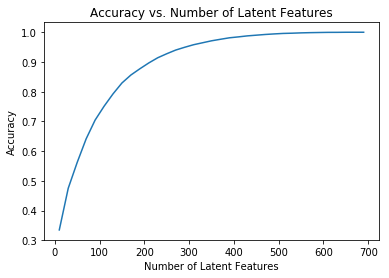

In [489]:
num_latent_feats = np.arange(10,700+10,20)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # take dot product
    user_item_est = np.around(np.dot(np.dot(u_new, s_new), vt_new))
    
    # compute error for each prediction to actual value
    diffs = np.subtract(user_item_matrix, user_item_est)
    
    # total errors and keep track of them
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`4.` From the above, we can't really be sure how many features to use, because simply having a better way to predict the 1's and 0's of the matrix doesn't exactly give us an indication of if we are able to make good recommendations.  Instead, we might split our dataset into a training and test set of data, as shown in the cell below.  

Use the code from question 3 to understand the impact on accuracy of the training and test sets of data with different numbers of latent features. Using the split below: 

* How many users can we make predictions for in the test set?  
* How many users are we not able to make predictions for because of the cold start problem?
* How many articles can we make predictions for in the test set?  
* How many articles are we not able to make predictions for because of the cold start problem?

In [471]:
df_train = df.head(40000)
df_test = df.tail(5993)

def create_test_and_train_user_item(df_train, df_test):
    '''
    INPUT:
    df_train - training dataframe
    df_test - test dataframe
    
    OUTPUT:
    user_item_train - a user-item matrix of the training dataframe 
                      (unique users for each row and unique articles for each column)
    user_item_test - a user-item matrix of the testing dataframe 
                    (unique users for each row and unique articles for each column)
    test_idx - all of the test user ids
    test_arts - all of the test article ids
    
    '''
    # Your code here
    user_item_train = df_train.groupby(['user_id', 'article_id'])['title'].count().unstack()
    user_item_train = (~user_item_train.isnull()).replace({True:1,False:0})
    
    user_item_test = df_test.groupby(['user_id', 'article_id'])['title'].count().unstack()
    user_item_test = (~user_item_test.isnull()).replace({True:1,False:0})
    
    train_idx = set(user_item_train.index)
    train_arts = set(user_item_train.columns)
    
    test_idx = set(user_item_test.index)
    test_arts = set(user_item_test.columns)
    
    
    
    return user_item_train, user_item_test, train_idx, train_arts, test_idx, test_arts

user_item_train, user_item_test, train_idx, train_arts, test_idx, test_arts = create_test_and_train_user_item(df_train, df_test)

In [472]:
user_item_test.head()

article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1432.0,1433.0,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1443.0
user_id,,,,,,,,,,,,,,,,,,,,,
2917,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3024,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3093,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3193,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3527,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [473]:
# number of users we make predictions for in the test set
len([test_i for test_i in test_idx if test_i in train_idx])

20

In [474]:
# number of users in the test set we are not able to make predictions for because of the cold start problem
len(test_idx) - len([test_i for test_i in test_idx if test_i in train_idx])

662

In [475]:
# number of articles we can make predictions for in the test set
len([test_a for test_a in test_arts if test_a in train_arts])

574

In [476]:
# number of articles in the test set we are not able to make predictions for because of the cold start problem
len(test_arts) - len([test_a for test_a in test_arts if test_a in train_arts])

0

In [477]:
# Replace the values in the dictionary below
a = 662 
b = 574 
c = 20 
d = 0 


sol_4_dict = {
    'How many users can we make predictions for in the test set?': c,# letter here, 
    'How many users in the test set are we not able to make predictions for because of the cold start problem?': a,# letter here, 
    'How many articles can we make predictions for in the test set?': b, # letter here,
    'How many articles in the test set are we not able to make predictions for because of the cold start problem?': d# letter here
}

t.sol_4_test(sol_4_dict)

Awesome job!  That's right!  All of the test articles are in the training data, but there are only 20 test users that were also in the training set.  All of the other users that are in the test set we have no data on.  Therefore, we cannot make predictions for these users using SVD.


`5.` Now use the **user_item_train** dataset from above to find **U**, **S**, and **V** transpose using SVD. Then find the subset of rows in the **user_item_test** dataset that you can predict using this matrix decomposition with different numbers of latent features to see how many features makes sense to keep based on the accuracy on the test data. This will require combining what was done in questions `2` - `4`.

Use the cells below to explore how well SVD works towards making predictions for recommendations on the test data.  

In [491]:
# fit SVD on the user_item_train matrix
u, s, vt = np.linalg.svd(user_item_train) # fit svd similar to above then use the cells below

u.shape, s.shape, vt.shape

((4487, 4487), (714,), (714, 714))

In [495]:
###### In this cell,I made masks for getting common rows and columns for train data and test data. 

# find user ids which are included both in train data set and test data set
common_user_ids = train_idx.intersection(test_idx)

# find article ids which are included both in train data set and test data set
common_article_ids = train_arts.intersection(test_arts)

train_mask_ids = user_item_train.index.isin(common_user_ids)

train_mask_articles = user_item_train.columns.isin(common_article_ids)

test_mask_ids = user_item_test.index.isin(common_user_ids)

test_mask_articles = user_item_test.columns.isin(common_article_ids)

print(train_mask_ids.shape, train_mask_ids.sum() )
print(train_mask_articles.shape, train_mask_articles.sum() )
print(test_mask_ids.shape, test_mask_ids.sum() )
print(test_mask_articles.shape, test_mask_articles.sum() )

# Just a little check these masks work
user_item_test.loc[test_mask_ids,test_mask_articles]

(4487,) 20
(714,) 574
(682,) 20
(574,) 574


article_id,0.0,2.0,4.0,8.0,9.0,12.0,14.0,15.0,16.0,18.0,...,1432.0,1433.0,1434.0,1435.0,1436.0,1437.0,1439.0,1440.0,1441.0,1443.0
user_id,,,,,,,,,,,,,,,,,,,,,
2917,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3024,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3093,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3193,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3527,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3532,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3684,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3740,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3777,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


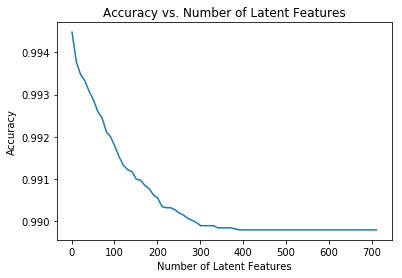

In [494]:
# Use these cells to see how well you can use the training 
# decomposition to predict on test data

num_latent_feats = np.arange(1,721,10)
sum_errs = []

for k in num_latent_feats:
    # restructure with k latent features
    s_new, u_new, vt_new = np.diag(s[:k]), u[:, :k], vt[:k, :]
    
    # get the prediction matrix for users both in train data and test data.
    user_item_est = np.around(np.dot(np.dot(u_new[train_mask_ids], s_new), vt_new[:,train_mask_articles]))
   
    # compute error and prediction values to actual values
    diffs = np.subtract(user_item_test.iloc[test_mask_ids,test_mask_articles], user_item_est)
    
    # keep track of errors
    err = np.sum(np.sum(np.abs(diffs)))
    sum_errs.append(err)
    
    
plt.plot(num_latent_feats, 1 - np.array(sum_errs)/df_train.shape[0]);
plt.xlabel('Number of Latent Features');
plt.ylabel('Accuracy');
plt.title('Accuracy vs. Number of Latent Features');

`6.` Use the cell below to comment on the results you found in the previous question. Given the circumstances of your results, discuss what you might do to determine if the recommendations you make with any of the above recommendation systems are an improvement to how users currently find articles? 

**Your response here.**

<a id='conclusions'></a>
### Extras
Using your workbook, you could now save your recommendations for each user, develop a class to make new predictions and update your results, and make a flask app to deploy your results.  These tasks are beyond what is required for this project.  However, from what you learned in the lessons, you certainly capable of taking these tasks on to improve upon your work here!


## Conclusion

> Congratulations!  You have reached the end of the Recommendations with IBM project! 

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations! 

In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Recommendations_with_IBM.ipynb'])